# Gas Used computations

How is gasUsed changing over time with Uniswap v3?  When we fetch gasUsed from tokentx the values vary wildly.  I think there are several reasons, but I will validate them here (hopefully).<br>
1. Gas fees are at the transaction level, but they can contain multiple 'actions or activities'.  i.e. you can do more than one swap in a transaction.<br>
2. There are likely at least two states of gasUsed at a minimum because of the two ways in which prices change: (1) when a swap occurs within the tick spacing (i.e. as a CPAMM) and (2) when there's a tick crossing and the liquidity concentration changes.<br>

## What is the distribution of gasUsed values in the last few hours?

In [221]:
import os
import re
import pytz
import numpy as np

import pandas as pd

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from itertools import combinations

In [2]:
# change the active path to the parent directory 
if True: 
    print("Moving active path to parent directory")
    os.chdir('..')
    print(os.getcwd())

Moving active path to parent directory
/Users/das/DATASCI210/arbitrage_playground


In [3]:
import src.arbutils as arbutils
import src.fetch as fetch

In [4]:
GRAPH_API_KEY = os.getenv("GRAPH_API_KEY")
if GRAPH_API_KEY is not None:
    print("GRAPH key Found.")

ETHERSCAN_API_KEY = os.getenv("ETHERSCAN_API_KEY")
if ETHERSCAN_API_KEY is not None:
    print("ETHERSCAN key Found.")

GRAPH key Found.
ETHERSCAN key Found.


First let's pick some pools to explore.  These are two pairs that could be used for arbitrage as they have compatible coins.  Notice that their fee tiers are different which may play a part in the gas fees...

In [5]:
pool0 = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
pool0_metadata = fetch.thegraph_request_pool_metadata(thegraph_api_key=GRAPH_API_KEY, pool_address=pool0)
print(pool0_metadata)

pool1 = "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"
pool1_metadata = fetch.thegraph_request_pool_metadata(thegraph_api_key=GRAPH_API_KEY, pool_address=pool1)
print(pool1_metadata)

{'feeTier': '500', 'id': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', 'liquidity': '6565879211441567682', 'sqrtPrice': '1385529490333307502535307586854607', 'tick': '195394', 'token0': {'decimals': '6', 'id': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', 'name': 'USD Coin', 'symbol': 'USDC'}, 'token1': {'decimals': '18', 'id': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'name': 'Wrapped Ether', 'symbol': 'WETH'}}
{'feeTier': '3000', 'id': '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8', 'liquidity': '1145303445789798027', 'sqrtPrice': '1387593769841124272664624080512131', 'tick': '195424', 'token0': {'decimals': '6', 'id': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', 'name': 'USD Coin', 'symbol': 'USDC'}, 'token1': {'decimals': '18', 'id': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'name': 'Wrapped Ether', 'symbol': 'WETH'}}


# USDC/WETH 3 hours



In [6]:
# datetime objects from the last day
#                     YYYY  MM  DD  HH  MM  SS
end_datetime = datetime.now(pytz.UTC)
start_datetime = end_datetime - timedelta(hours=3)

p0  = fetch.thegraph_request(GRAPH_API_KEY, 
                 ETHERSCAN_API_KEY, 
                 pool0, 
                 old_date=start_datetime, 
                 new_date=end_datetime)

Using given dates: 2025-01-20 01:44:02.756574+00:00 to 2025-01-20 04:44:02.756574+00:00
Processing data from timestamp: 1737337442 to 1737348242
0: [1737348202-1737348242]found 905 swaps from 1737337451 to 1737348203
Found 906 swaps from 1737337451 to 1737348203
Swaps Found (Prior to Merge, Prior to drop_duplicates): (906, 30)
Merging token transactions from blocks 21662494 to 21663387 
  21662494 to 21663387 
Swaps Found (Prior to Merge): (906, 30)
Found 909 Token Tx between 1737337451 and 1737348203
Swaps Found (After Merge): (906, 30)


In [7]:
p0.head()

,transactionHash,datetime,timeStamp,sqrtPriceX96,blockNumber,gasPrice,gasUsed,tick,amount0,amount1,liquidity
0,0x355fbe83f479ba578268e724c19cfd6279109833b1d3...,2025-01-20 01:44:11+00:00,1737337451,1.404620e+33,21662494,7.305568e+10,121298.0,195668.0,-80891.409099,25.428683,6.565879e+18
1,0x1cefcb60c1563d44b4ea610a0707d3ff31da8de582a0...,2025-01-20 01:44:23+00:00,1737337463,1.404739e+33,21662495,6.707941e+10,144359.0,195670.0,-110796.668135,34.830882,6.565879e+18
2,0x360ba0698aa8ae60989639a0569663c24673f71072e8...,2025-01-20 01:44:23+00:00,1737337463,1.404055e+33,21662495,8.963339e+10,247713.0,195660.0,91626.899061,-28.773298,6.565879e+18
3,0x3afe4eb9769cf8a1302eba36319e12bc5e16ce610275...,2025-01-20 01:44:35+00:00,1737337475,1.405743e+33,21662496,2.095615e+11,151292.0,195684.0,-162078.327042,51.013437,6.565879e+18
4,0x40a51bb2ca94cbb667ed70d7c3150f8d2f60c52c0ad9...,2025-01-20 01:44:59+00:00,1737337499,1.405414e+33,21662498,7.069448e+10,123130.0,195680.0,53076.682772,-16.696969,6.565879e+18


First we can look at the quantiles.  there is a great deal of variability even in the last 3 hours...

In [8]:
(p0['gasUsed'] / 1e6).describe()

count    906.000000
mean       0.268665
std        0.200074
min        0.107519
25%        0.151367
50%        0.213411
75%        0.301839
max        1.476374
Name: gasUsed, dtype: float64

Even if  you just look at the most frequent occurence (i.e. this is the exact amount of opcodes run for this pool), you can see this is not a process that is likely to repeat in general.

In [9]:
p0.gasUsed.value_counts().head(10)

gasUsed
121358.0    5
123863.0    3
148820.0    3
121312.0    3
121364.0    3
151362.0    3
153739.0    3
123772.0    3
676653.0    2
307780.0    2
Name: count, dtype: int64

Here is a general distribution.  the tails are long...

<Axes: >

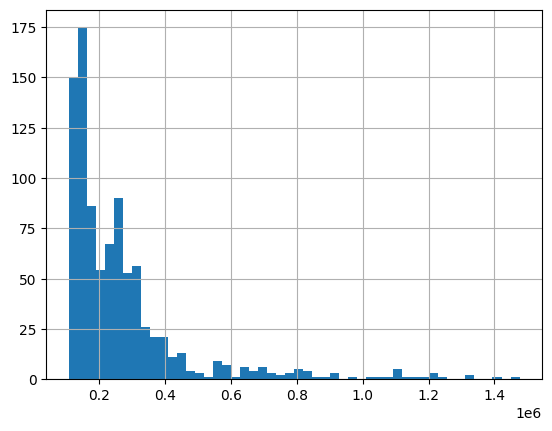

In [10]:
p0.gasUsed.hist(bins=50)

## Hypothesis: transactions with more than one type of activity are why gasUsed is so high
(i.e. an arbitrage transaction will be must simpler).

In [11]:
pd.set_option('display.max_colwidth', 100) 
p0['gasPrice'] = p0['gasPrice'] / 1e9 # put the units in GWEI.
p0[['transactionHash','gasPrice','gasUsed']].sort_values(by='gasUsed')

,transactionHash,gasPrice,gasUsed
129,0x633fc796efdeb6b264f1517a2c3cd20a13e6e2d2676f221b214303e2b0678fab,76.391826,107519.0
887,0x06d706ea60e2500bc106840051cdaac0b0f4556529fa71de17add96e882ca9c6,25.101797,114065.0
369,0xcac108ca7380c073b456bfc4903305c14b51c2480c309246f6127a9f1e087b39,302.150224,114514.0
670,0x6e25eaa07f983299a1320d0f44d32934f836aecf6e121262e2ef755b39776481,22.153770,115150.0
177,0xa30424a0f12ade5d74812d2119a3a7a984ed5e0feb586da34452101148d55cee,47.371449,115193.0
...,...,...,...
80,0xef00f060fb40dab4a58666a81437df13763e692adf01198593c96b39d06e5a98,62.189785,1256297.0
158,0x33b1bc47069bee8b2fcdc89c78354d2613c964354fa00575d3313e0c82dd470c,53.632840,1328448.0
159,0x33b1bc47069bee8b2fcdc89c78354d2613c964354fa00575d3313e0c82dd470c,53.632840,1328448.0
522,0x79a09de20a40bab3b83edd8672c99ac56c4e7d42489145703638ceb85a3c733a,29.015857,1416779.0


### Low End gasUsed

So for "0x633fc796efdeb6b264f1517a2c3cd20a13e6e2d2676f221b214303e2b0678fab" (gasUsed=107,519), the transaction is indeed a single swap! Additionally, you can see two tokens transferred, which is expected for a swap. see link [here](https://etherscan.io/tx/0x633fc796efdeb6b264f1517a2c3cd20a13e6e2d2676f221b214303e2b0678fab). <br>

### High End gasUsed

So for 0xfb7044e2b89ca140caf66a9cb8da772e2e61dfe41b10ffdcd3aeb22c5e7a271c (gasUsed=1,476,374), the transaction is 8 swaps and 22 token transfers!  if you divide it out, the gasUsed per swap is more like 184546, but I'm not exactly sure how token transfers play into gasUsed yet.  see link [here](https://etherscan.io/tx/0xfb7044e2b89ca140caf66a9cb8da772e2e61dfe41b10ffdcd3aeb22c5e7a271c).<br>




## Deeper Dive into Swap Event Transactions

In [12]:
p0[['transactionHash','gasPrice','gasUsed','blockNumber']].sort_values(by='gasUsed')

,transactionHash,gasPrice,gasUsed,blockNumber
181,0x633fc796efdeb6b264f1517a2c3cd20a13e6e2d2676f221b214303e2b0678fab,76.391826,107519.0,21662632
421,0xcac108ca7380c073b456bfc4903305c14b51c2480c309246f6127a9f1e087b39,302.150224,114514.0,21662862
722,0x6e25eaa07f983299a1320d0f44d32934f836aecf6e121262e2ef755b39776481,22.153770,115150.0,21663126
229,0xa30424a0f12ade5d74812d2119a3a7a984ed5e0feb586da34452101148d55cee,47.371449,115193.0,21662690
416,0x6b032c87bf7e867965ea5a5121f64e75802b9fab87e537cdef039f7305df2630,42.007245,115546.0,21662861
...,...,...,...,...
132,0xef00f060fb40dab4a58666a81437df13763e692adf01198593c96b39d06e5a98,62.189785,1256297.0,21662584
211,0x33b1bc47069bee8b2fcdc89c78354d2613c964354fa00575d3313e0c82dd470c,53.632840,1328448.0,21662667
210,0x33b1bc47069bee8b2fcdc89c78354d2613c964354fa00575d3313e0c82dd470c,53.632840,1328448.0,21662667
574,0x79a09de20a40bab3b83edd8672c99ac56c4e7d42489145703638ceb85a3c733a,29.015857,1416779.0,21662996


Searching through the transaction receipt you can see all the activity, at least in principle...there are actions that I am not familiar with yet, but you can see the difference in activity between a 'cheap' swap and an 'expensive' one.

In [138]:
def get_events(logs,verbose=True):
    swap_event_sig = "0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67"
    token_transfer_events = "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
    se_cnt = 0
    tte_cnt = 0
    total_cnt = 0
    
    for log in logs:
        if swap_event_sig in log['topics']:
            se_cnt += 1
        elif token_transfer_events in log['topics']:
            tte_cnt += 1
    total_cnt += len(logs)
    if verbose:
        print(f"including {se_cnt} swap events, {tte_cnt} token transfer events.")

    return se_cnt, tte_cnt, total_cnt

### Expensive Swap Transaction (gasUsed 1.47M)

In [140]:

se_cnt = 0
tte_cnt = 0

# expensive swap...
reciept = fetch.etherscan_request_transaction_receipt(ETHERSCAN_API_KEY, "0xfb7044e2b89ca140caf66a9cb8da772e2e61dfe41b10ffdcd3aeb22c5e7a271c")
print(f"{len(reciept['logs'])} events",end=" ") 
_ = get_events(reciept['logs'])

47 events including 7 swap events, 24 token transfer events.


if I assume that token transfers are 21000 gas units, then we get: 504000 units for 24 token transfers alone...

### Cheap Swap Transaction (107k)

In [141]:
# cheap swap...
reciept = fetch.etherscan_request_transaction_receipt(ETHERSCAN_API_KEY, "0x633fc796efdeb6b264f1517a2c3cd20a13e6e2d2676f221b214303e2b0678fab")
print(f"{len(reciept['logs'])} events",end=" ") 
_ = get_events(reciept['logs'])

3 events including 1 swap events, 2 token transfer events.


What about the top ten least expensive transactions...

In [145]:
p0_new = p0.sort_values(by='gasUsed')
for i, row in p0_new.iloc[:10].iterrows():
    print(f"{row['transactionHash']}, ({row['gasUsed']}): ",end=" ")
    _ = get_events(fetch.etherscan_request_transaction_receipt(ETHERSCAN_API_KEY,row['transactionHash'])['logs'])

0x633fc796efdeb6b264f1517a2c3cd20a13e6e2d2676f221b214303e2b0678fab, (107519.0):  including 1 swap events, 2 token transfer events.
0x06d706ea60e2500bc106840051cdaac0b0f4556529fa71de17add96e882ca9c6, (114065.0):  including 1 swap events, 2 token transfer events.
0xcac108ca7380c073b456bfc4903305c14b51c2480c309246f6127a9f1e087b39, (114514.0):  including 1 swap events, 2 token transfer events.
0x6e25eaa07f983299a1320d0f44d32934f836aecf6e121262e2ef755b39776481, (115150.0):  including 1 swap events, 2 token transfer events.
0xa30424a0f12ade5d74812d2119a3a7a984ed5e0feb586da34452101148d55cee, (115193.0):  including 1 swap events, 2 token transfer events.
0x6b032c87bf7e867965ea5a5121f64e75802b9fab87e537cdef039f7305df2630, (115546.0):  including 1 swap events, 2 token transfer events.
0x79007950956cc8c97b8e2f0fb845546b38707373a65054b8722f58fd55132251, (116595.0):  including 1 swap events, 2 token transfer events.
0x8e7c5adafa8f8e970c33127f9921c3e98d650812d286a46b9c04c6ad2a7cef5d, (116654.0):  in

ok now let's try and find when it starts to look a little more complicated, which gives us a sense of the variance for an apples to apples comparison of events at least.

In [75]:
p0_new = p0.sort_values(by='gasUsed')
for i, row in p0_new.iloc[200:220].iterrows():
    print(f"{row['transactionHash']}, ({row['gasUsed']}): ",end=" ")
    _ = get_events(fetch.etherscan_request_transaction_receipt(ETHERSCAN_API_KEY,row['transactionHash'])['logs'])

0xa6b41a633af0d5952719b6cc4cc6481dbf93fdb5b00742aa406d3540c80b609a, (150141.0):  including 1 swap events, 2 token transfer events.
0x80d794f16b15bfb305c0c9f44b3429c7d7e5fa016af8f14fa481816c9bad9d62, (150143.0):  including 1 swap events, 2 token transfer events.
0x115d609677079967a112647f87cc580f5ba44688922dc7c560a1dc94e71cfa43, (150145.0):  including 1 swap events, 2 token transfer events.
0x72e1f69ac8858439a870d17383b5d3d581e6c6274f92a0dafc84e4632bb69f1b, (150188.0):  including 1 swap events, 2 token transfer events.
0x9473910d6bc1ce3b51920cfe3694c7a30429f9f9ea97ee602f01d90bd4dfeae5, (150308.0):  including 1 swap events, 2 token transfer events.
0xb8b04bd1cb6f7583bf04e5e9687039f5c12f863a8392fcdb2fe53d91f8ccc0ed, (150320.0):  including 1 swap events, 2 token transfer events.
0xa349443abf93c827d698886a418253c372e1af200d6312c2b85de45fabf0e399, (150382.0):  including 1 swap events, 2 token transfer events.
0x97f4ee22a8e0c8a25be4ae13b1bd9aecacefaccf398b81a9590bea5a9bebf376, (150431.0):  in

so the first time you see something other than 1 swap and 2 token transfers is at 150k units of work!  wow and it looks like it keeps going.  

In [76]:
p0_new = p0.sort_values(by='gasUsed')
for i, row in p0_new.iloc[500:510].iterrows():
    print(f"{row['transactionHash']}, ({row['gasUsed']}): ",end=" ")
    _ = get_events(fetch.etherscan_request_transaction_receipt(ETHERSCAN_API_KEY,row['transactionHash'])['logs'])

0x3a00b0a64f89cc052258b2e8d5957a27ae8a9a06ecc5f77c665958bb63d94bec, (230326.0):  including 2 swap events, 6 token transfer events.
0xc30251de6aa62f56c24fc31a0c6c31638a6f84f24f9dd37cb85c92fc7fade4bd, (230548.0):  including 2 swap events, 6 token transfer events.
0x483fbaf95c685699fa605a4b9b454c42330ae3ac87f0cdcb4421b7e0030279dc, (230798.0):  including 2 swap events, 6 token transfer events.
0x223ef645c2f7856da16cf5d3610ec63dbb3d63c5c69e05c12a6c0c2b9fde1bb8, (230861.0):  including 2 swap events, 6 token transfer events.
0xd8c6d152ad8698e54ae667d83b6ce8196529347bf106ea6680f82032e72cfbd6, (230959.0):  including 2 swap events, 6 token transfer events.
0x9a7f0e5072f018e4491788cbab57f21de910f04f81951f6f9e47a02d2da6f1b0, (231290.0):  including 1 swap events, 2 token transfer events.
0x678ce4a09689b5f203cb4ac8d73fc6e047f99c1f23aa28209d0d674259ce36e6, (231408.0):  including 2 swap events, 5 token transfer events.
0xa045ac583b1cca2bd719cf29271b89d61f771c440688a2590c8650750b68f855, (231659.0):  in

the swap that uses 231290 also is transferring an amount of 318.241 ETH!  whereas the other swaps at the low end are small in comparison...

### Total Events vs. gasUsed

Below we do a deeper look at all the transactions in the last 3 hours and exactly how many swap events and token transfer events occur.

In [77]:
p0_new['swap_events']=None
p0_new['token_transfer_events']=None
p0_new['total_events']=None

In [146]:
def get_txn_events(row):
    row['swap_events'],row['token_transfer_events'],row['total_events'] = get_events(fetch.etherscan_request_transaction_receipt(ETHERSCAN_API_KEY,row['transactionHash'])['logs'],verbose=False)
    print(".",end="")
    return row

p0_new = p0_new.apply(get_txn_events,axis=1)

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Now that we have swap events and token transfers collected, we can look at the relationship with gasUsed and events.  Looks like there is a strong correlation between total events and gasUsed.

(0.0, 65.0)

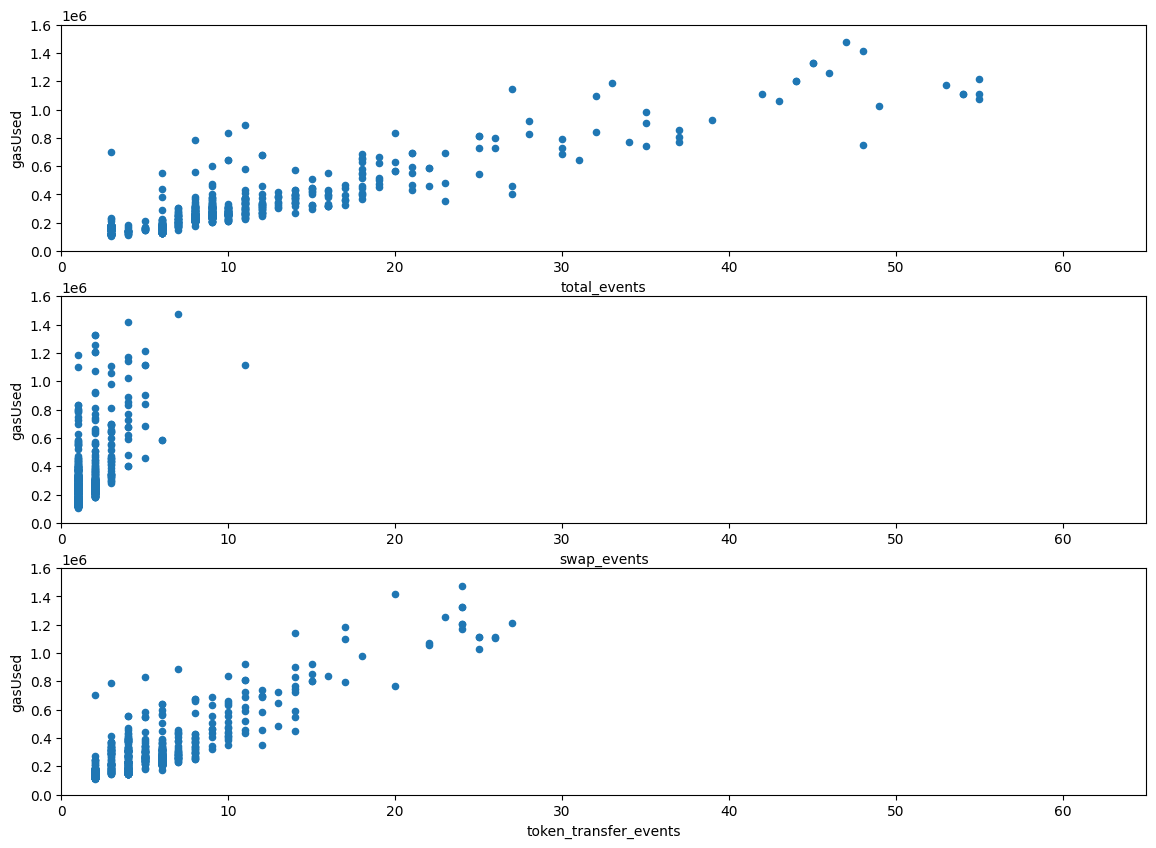

In [162]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(14, 10))

p0_new.plot.scatter(x='total_events',y='gasUsed',ax=axs[0])
axs[0].set_ylim(0,1.6e6)
axs[0].set_xlim(0,65)
p0_new.plot.scatter(x='swap_events',y='gasUsed',ax=axs[1])
axs[1].set_ylim(0,1.6e6)
axs[1].set_xlim(0,65)
p0_new.plot.scatter(x='token_transfer_events',y='gasUsed',ax=axs[2])
axs[2].set_ylim(0,1.6e6)
axs[2].set_xlim(0,65)


Knowing that token transfers are typically 21000, i adjusted the swap events category to remove the effect of token transfers...

(0.0, 65.0)

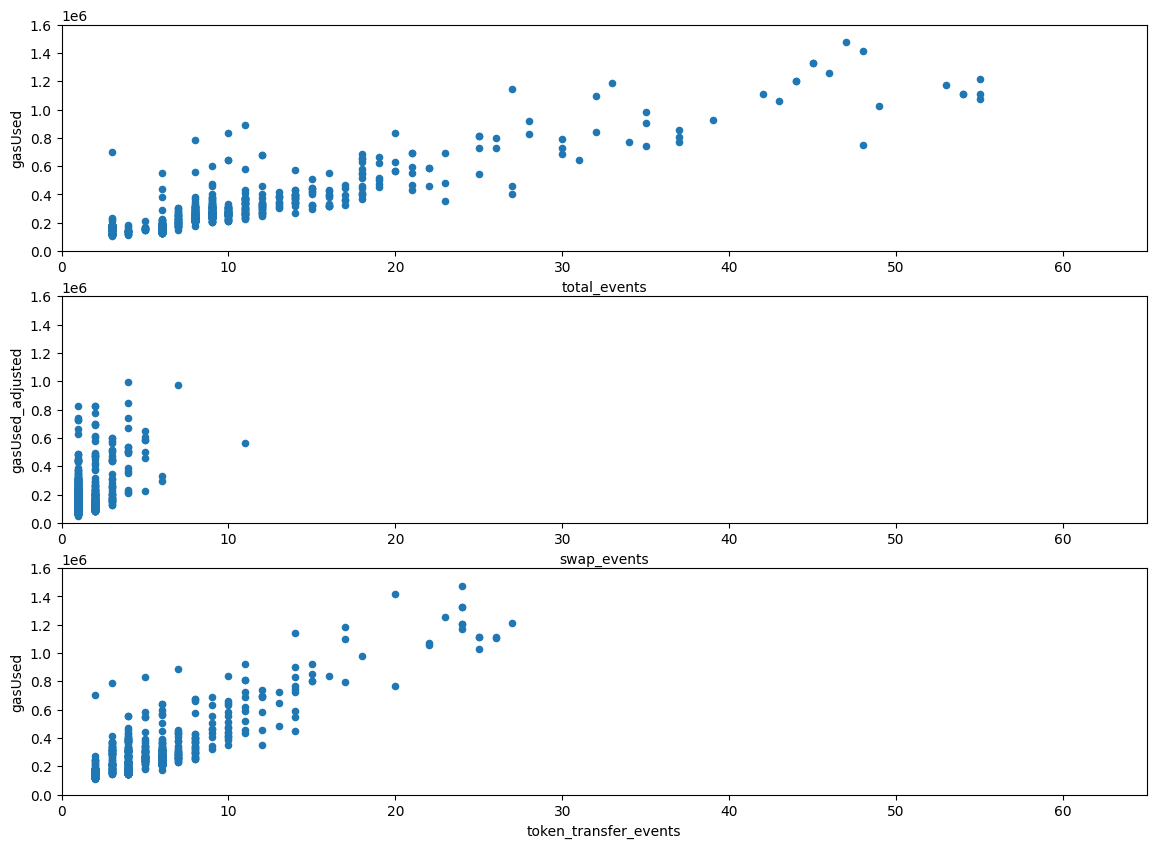

In [161]:
fig, axs = plt.subplots(3, 1, figsize=(14, 10))

p0_new['gasUsed_adjusted'] = None
def gas_adjustment(row):
    row['gasUsed_adjusted'] = row['gasUsed'] - 21000 * row['token_transfer_events']
    return row
p0_new = p0_new.apply(gas_adjustment,axis=1)

p0_new.plot.scatter(x='total_events',y='gasUsed',ax=axs[0])
axs[0].set_ylim(0,1.6e6)
axs[0].set_xlim(0,65)
p0_new.plot.scatter(x='swap_events',y='gasUsed_adjusted',ax=axs[1])
axs[1].set_ylim(0,1.6e6)
axs[1].set_xlim(0,65)
p0_new.plot.scatter(x='token_transfer_events',y='gasUsed',ax=axs[2])
axs[2].set_ylim(0,1.6e6)
axs[2].set_xlim(0,65)

Even if i only show swap events where there is only one (i.e. not bundling), there isn't an obvious correlation with amounts in transactions.

<Axes: xlabel='amount0_abs', ylabel='gasUsed'>

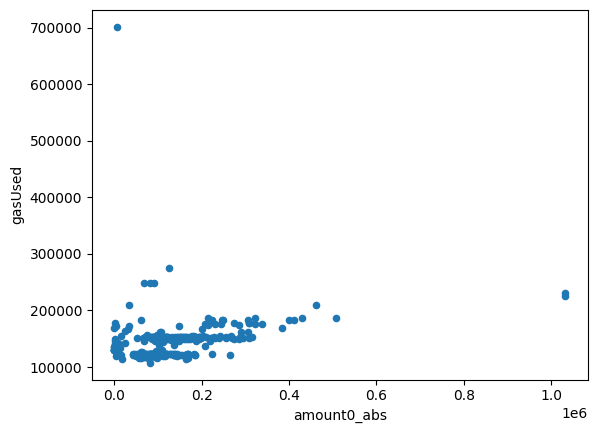

In [170]:
p0_new['amount0_abs'] = np.abs(p0_new['amount0'])
p0_new[(p0_new['swap_events']==1) & (p0_new['token_transfer_events']==2)].plot.scatter(x='amount0_abs',y='gasUsed')

Taking a closer look at this outlier...looks like arbitrage.  In this case, it looks like he put his gas limits high.  Would a contract attempt to run up his fees?

In [99]:
p0_new[(p0_new['gasUsed']>500000) & (p0_new['amount0_abs']<0.1e6) & (p0_new['swap_events']==1) & (p0_new['token_transfer_events']==2)]

,transactionHash,datetime,timeStamp,sqrtPriceX96,blockNumber,gasPrice,gasUsed,tick,amount0,amount1,liquidity,swap_events,token_transfer_events,amount0_abs
404,0x6ca24c94b13a22715334bdda1bedae46decf13c631efe1337654e3c273c02b3f,2025-01-20 03:02:59+00:00,1737342179,1.394657e+33,21662888,28.759008,701589.0,195526.0,-6269.670409,1.943705,6.565879e+18,1,2,6269.670409


So here is the distribution of single swap events with 2 token transfers

In [136]:
p0_new[(p0_new['swap_events']==1) & (p0_new['token_transfer_events']==2)]['gasUsed'].describe()

count       338.000000
mean     144257.071006
std       38510.942358
min      107519.000000
25%      122507.000000
50%      146157.000000
75%      152696.750000
max      701589.000000
Name: gasUsed, dtype: float64

<Axes: >

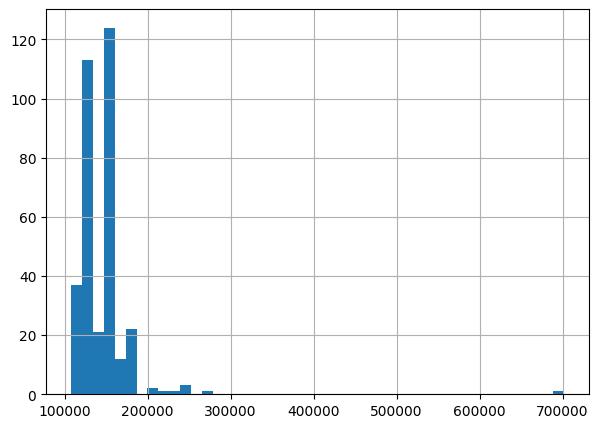

In [165]:
fig2, axs2 = plt.subplots(1, 1, figsize=(7, 5))

p0_new[(p0_new['swap_events']==1) & (p0_new['token_transfer_events']==2)]['gasUsed'].hist(bins=45,ax=axs2)

In [167]:

p0_new[(p0_new['swap_events']==2) & (p0_new['token_transfer_events']==4)]['gasUsed'].describe()


count        32.000000
mean     234517.625000
std       88612.004542
min      179881.000000
25%      190554.000000
50%      210478.500000
75%      228513.000000
max      555891.000000
Name: gasUsed, dtype: float64

<Axes: >

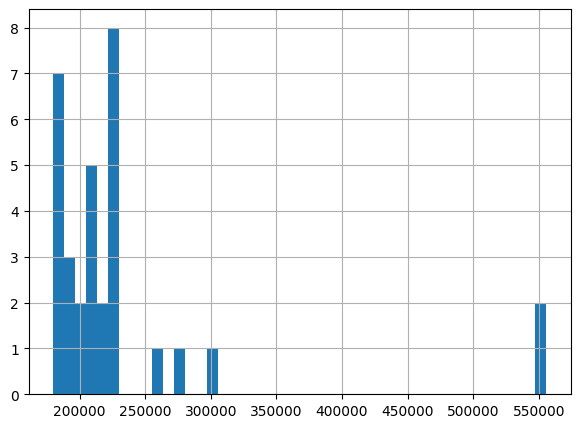

In [168]:
fig2, axs2 = plt.subplots(1, 1, figsize=(7, 5))
p0_new[(p0_new['swap_events']==2) & (p0_new['token_transfer_events']==4)]['gasUsed'].hist(bins=45,ax=axs2)

To perform prediction on gas fees (i.e. gasPrice x gasUsed), the type of transaction i am expecting matters a good bit.  For example the top graph is only for 1 swap and 2 token transfers.  the bottom graph is for 2 swaps and 4 token transfers (i.e. arbitrage).

Gas Used Average (simple transfers): 144257.07100591715
Gas Used Average (all) : 268664.8697571744
Gas Used Average (simple transfers): 234517.625
Gas Used Average (all) : 268664.8697571744


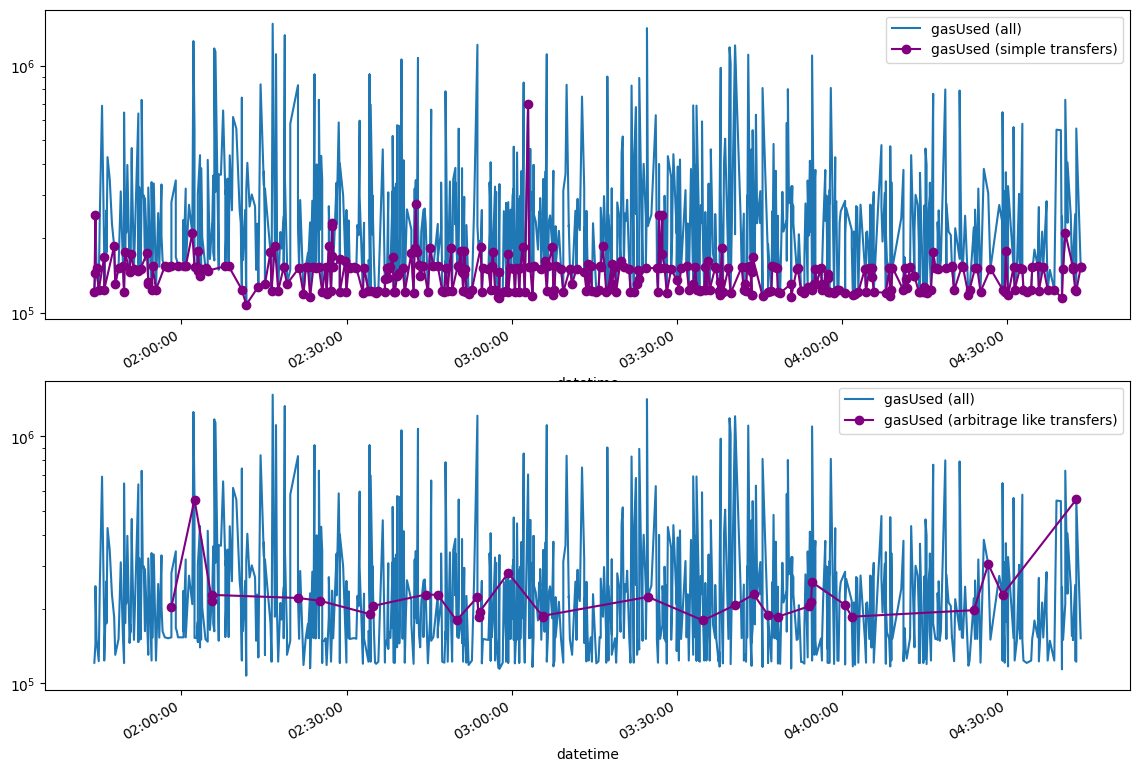

In [223]:
fig4, axs4 = plt.subplots(2, 1, figsize=(14, 10))
p0_new_short = p0_new.iloc[-1000:]

p0_new_short_simple = p0_new_short[(p0_new_short['swap_events']==1) & (p0_new_short['token_transfer_events']==2)  ]
print(f"Gas Used Average (simple transfers): {p0_new_short_simple['gasUsed'].mean()}")
print(f"Gas Used Average (all) : {p0_new_short['gasUsed'].mean()}")
p0_new_short.sort_values(by='datetime').plot(x='datetime',y='gasUsed',ax=axs4[0])
p0_new_short_simple.sort_values(by='datetime').plot(x='datetime',y='gasUsed',ax=axs4[0],color='purple',marker='o')
axs4[0].set_yscale('log')
axs4[0].legend(['gasUsed (all)','gasUsed (simple transfers)'])
axs4[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs4[0].xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjusts tick frequency

p0_new_short_simple = p0_new_short[(p0_new_short['swap_events']==2) & (p0_new_short['token_transfer_events']==4)  ]
print(f"Gas Used Average (simple transfers): {p0_new_short_simple['gasUsed'].mean()}")
print(f"Gas Used Average (all) : {p0_new_short['gasUsed'].mean()}")
p0_new_short.sort_values(by='datetime').plot(x='datetime',y='gasUsed',ax=axs4[1])
p0_new_short_simple.sort_values(by='datetime').plot(x='datetime',y='gasUsed',ax=axs4[1],color='purple',marker='o')
axs4[1].set_yscale('log')
axs4[1].legend(['gasUsed (all)','gasUsed (arbitrage like transfers)'])
axs4[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs4[1].xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjusts tick frequency